# Project: Marketing A/B Test Analysis

### Project Overview

The marketing team has launched a new advertising campaign and needs to determine if it's delivering a positive return on investment. This analysis will provide a data-driven recommendation on whether to continue, modify, or halt the campaign.

To do this, we will compare the conversion rate of a **treatment group** (users who saw the new ad) against a **control group** (users who saw a public service announcement, or PSA) using a randomized A/B test.


# 1. Objectives

The primary goal is to determine if the new ad campaign resulted in a statistically significant increase in conversions. 

To achieve this, we will:

1. **Clean and validate** the raw dataset.
2. **Explore the data (EDA)** to understand group distributions and baseline metrics.
3. **Perform Power Analysis** to confirm the experiment's sensitivity.
4. **Run a Z-test for proportions** to check for statistical significance.
5. **Compute confidence intervals** to quantify the effect size.
6. **Formulate a clear conclusion and recommendation** for business stakeholders.

# 2. Data Overview

The dataset contains user-level information from the A/B test.

- **user_id**: Unique user identifier.
- **test_group**: 'ad' (treatment group) or 'psa' (control group).
- **converted**: `True` if a purchase was made, `False` otherwise.
- **total_ads**: Number of ads seen by the user.
- **most_ads_day**: Weekday with the highest ad exposure for the user.
- **most_ads_hour**: Hour of the day with the highest ad exposure for the user.

# 3. Load Packages

We’ll import the necessary libraries for data manipulation, visualization, and statistical testing.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest, proportion_confint, confint_proportions_2indep

# 4. Load and Clean Data

The first step is to load the data and perform essential cleaning to ensure its quality and consistency for analysis.

In [8]:
df = pd.read_csv("marketing_AB.csv")
print("Data loaded. Shape:", df.shape)

Data loaded. Shape: (588101, 7)


In [9]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [10]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
df['converted'] = df['converted'].astype(int) 

In [12]:
# To ensure consistency and prevent errors in later steps, column names are standardized to lowercase and any spaces are replaced with underscores.
df.columns = df.columns.str.strip().str.replace(' ', '_')
print("Cleaned DataFrame head:")
print(df.head(2))

Cleaned DataFrame head:
   user_id test_group  converted  total_ads most_ads_day  most_ads_hour
0  1069124         ad          0        130       Monday             20
1  1119715         ad          0         93      Tuesday             22


In [13]:
# A critical check for any user-level analysis is to ensure there are no duplicate user IDs, as this could compromise the integrity of the test.
dup_count = df.duplicated(subset=['user_id']).sum()
print(f"Duplicate user_id entries found: {dup_count}")

Duplicate user_id entries found: 0


In [14]:
# The check confirms our dataset has one unique record per user, and our data cleaning is complete.

# 5. Exploratory Data Analysis (EDA)

Now we'll explore the dataset to check for anomalies, understand the distribution of users, and get a first look at the conversion rates.

### 5.1 Basic Checks

First, a quick check for missing data and data types.

In [17]:
print(df.info(), '\n')
print('Missing values by column:')
print(df.isnull().sum(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  int32 
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: int32(1), int64(3), object(2)
memory usage: 24.7+ MB
None 

Missing values by column:
user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64 



 A preliminary check confirms the dataset contains **588,101 entries** and has **no missing values**. This indicates a high-quality dataset, simplifying the pre-processing stage.

###  5.2 Conversion by test group

In [20]:
group_counts = df.groupby('test_group')['converted'].agg(['count','sum'])
group_counts['rate'] = group_counts['sum'] / group_counts['count']
print('Conversion summary by group:')
print(group_counts, '\n')

Conversion summary by group:
             count    sum      rate
test_group                         
ad          564577  14423  0.025547
psa          23524    420  0.017854 



This is our most important summary table. Initial observation shows a clear difference in performance:

- The **'ad' (treatment) group** has a raw conversion rate of **2.55%**.
- The **'psa' (control) group's** rate is **1.79%**.

The next steps will determine if this observed difference is statistically significant or simply due to random chance.

### 5.3 Visualizations
#### 5.3.1 User distribution by group

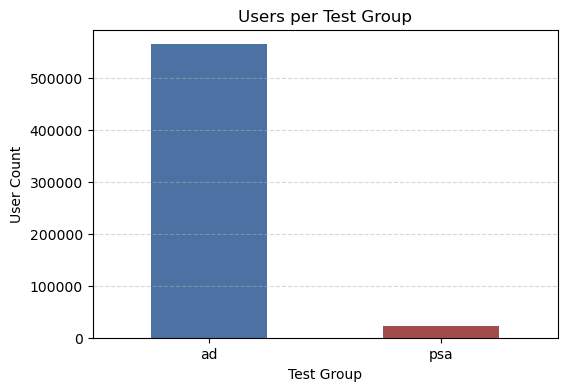

In [23]:
plt.figure(figsize=(6,4))
df['test_group'].value_counts().plot(kind='bar',color=['#4B72A3', '#A34B4B'])
plt.title('Users per Test Group')
plt.xlabel('Test Group')
plt.ylabel('User Count')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks( rotation = 0)
plt.show()

A crucial observation is the significant imbalance in group sizes. The 'ad' (treatment) group is substantially larger than the 'psa' (control) group. While our statistical tests can account for differing sample sizes, in a real-world scenario, this would prompt an immediate investigation into the randomization process to ensure there wasn't an implementation error.

#### 5.3.2 Conversion rate by group

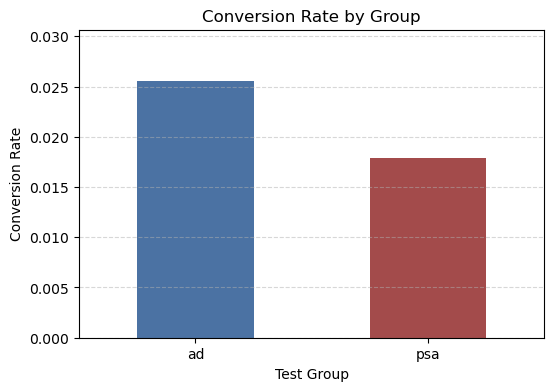

In [26]:
plt.figure(figsize=(6, 4))
group_rates = group_counts['rate']
group_rates.plot(kind='bar', color=['#4B72A3', '#A34B4B'])
plt.title('Conversion Rate by Group')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.ylim(0, group_rates.max() * 1.2)
plt.xticks(rotation=0)
plt.show()

This provides a strong preliminary signal that the ad campaign may be effective. The subsequent hypothesis test will determine if this visual difference is statistically significant.

#### 5.3.3 Distribution of total ads seen

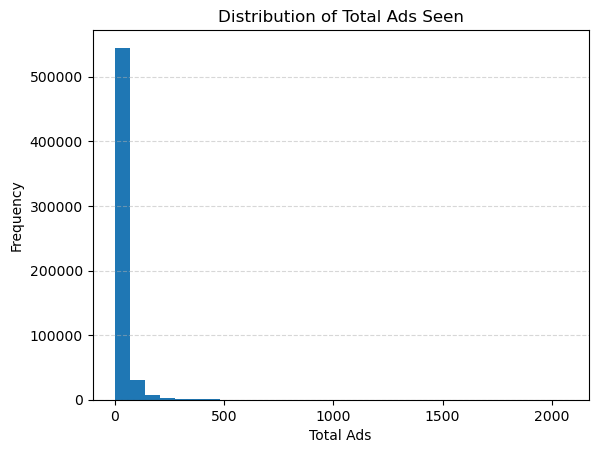

In [29]:
df['total_ads'].plot(kind='hist', bins=30)
plt.title('Distribution of Total Ads Seen')
plt.xlabel('Total Ads')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.show()

This shows a classic right-skew: most users saw a few ads, but a handful saw a lot. This skew is interesting but doesn't affect our main test. However, it opens up a great question for a follow-up analysis: does more exposure lead to more conversions?

#### 5.4.4 Peak ad exposure times

In [32]:
weekday_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday']
df['most_ads_day'] = pd.Categorical(
    df['most_ads_day'],
    categories=weekday_order,
    ordered=True
)

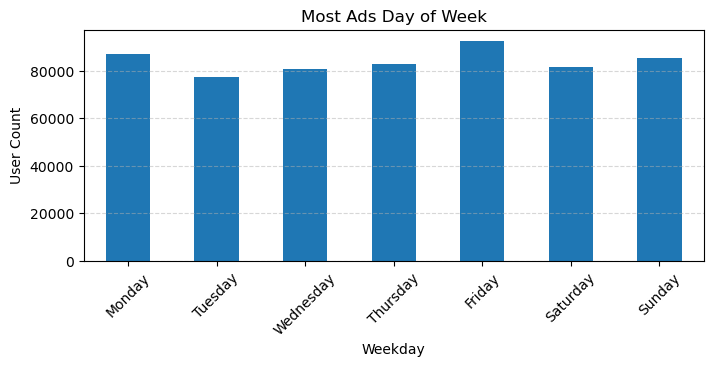

In [33]:
plt.figure(figsize=(8,3))
df['most_ads_day'].value_counts(sort = False).plot(kind='bar')
plt.title('Most Ads Day of Week')
plt.xlabel('Weekday')
plt.ylabel('User Count')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(rotation = 45)
plt.show()

**Most Ads Day of Week:** Ad exposure appears to be relatively consistent throughout the week, with no single day showing a dramatic spike. This suggests user activity is well-distributed.


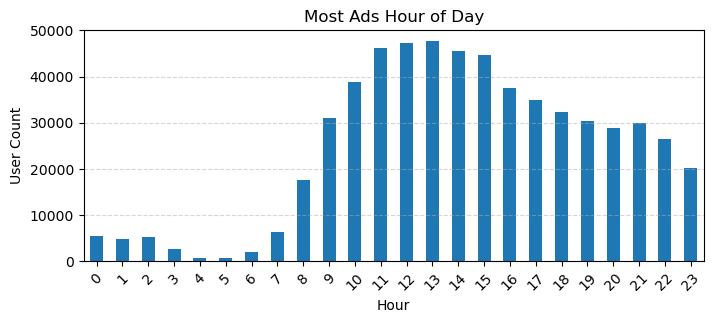

In [35]:
plt.figure(figsize=(8,3))
df['most_ads_hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Most Ads Hour of Day')
plt.xlabel('Hour')
plt.ylabel('User Count')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.xticks(rotation = 45)
plt.show()


**Most Ads Hour of Day:** There is a clear pattern in hourly ad exposure. Activity is lowest in the early morning hours and peaks during the afternoon (around 11:00 - 15:00). 

**Business Insight:** This hourly trend could be leveraged for future campaign optimization. For example, the marketing team could focus more of the ad budget during these peak hours to maximize reach and potential impact.

# 6. Power Analysis: Minimum Detectable Effect (MDE)

Since the experiment has already run, we can perform a retrospective power analysis to find the **Minimum Detectable Effect (MDE)**. This tells us the smallest lift our experiment was powered to reliably detect (with 80% power at α=0.05).

In [39]:
# Parameters from the experiment
nobs_ad = group_counts.loc['ad', 'count']
nobs_psa = group_counts.loc['psa', 'count']
baseline_rate = group_counts.loc['psa', 'rate']
alpha = 0.05
power = 0.8

# Calculate the MDE (we need to solve for `effect_size`)
effect_size = zt_ind_solve_power(
    nobs1=nobs_psa,
    alpha=alpha,
    power=power,
    ratio=nobs_ad / nobs_psa,
    alternative='larger'
)

mde_absolute = effect_size * baseline_rate

print(f"Baseline Conversion Rate (PSA): {baseline_rate:.2%}")
print(f"Minimum Detectable Effect (Absolute Lift): {mde_absolute:.4%}")
print(f"\nOur observed lift was {(group_counts.loc['ad', 'rate'] - baseline_rate):.4%}, which is much larger than the MDE.")
print("Conclusion: The experiment was more than adequately powered to detect a meaningful effect.")


Baseline Conversion Rate (PSA): 1.79%
Minimum Detectable Effect (Absolute Lift): 0.0295%

Our observed lift was 0.7692%, which is much larger than the MDE.
Conclusion: The experiment was more than adequately powered to detect a meaningful effect.


# 7. Hypothesis Testing (One-sided Z-test)

We will now perform a formal hypothesis test to determine if the increase in conversion rate for the ad group is statistically significant.

- **H₀ (Null Hypothesis):** The conversion rate of the ad group is less than or equal to the conversion rate of the PSA group. (p_ad <= p_psa)
- **H₁ (Alternative Hypothesis):** The conversion rate of the ad group is greater than the conversion rate of the PSA group. (p_ad > p_psa)

We use a significance level (alpha) of 0.05.

In [41]:
count_psa = int(group_counts.loc['psa', 'sum'])
count_ad = int(group_counts.loc['ad', 'sum'])
nobs_psa = int(group_counts.loc['psa', 'count'])
nobs_ad = int(group_counts.loc['ad', 'count'])

# Perform the Z-test
stat, pval = proportions_ztest(
    count=[count_ad, count_psa],
    nobs=[nobs_ad, nobs_psa],
    alternative='larger'
)

print(f'Z-statistic: {stat:.3f}')
print(f'P-value: {pval:.4f}')

Z-statistic: 7.370
P-value: 0.0000


The p-value is extremely small (effectively 0), which is well below our significance level of 0.05. Therefore, we **reject the null hypothesis**. This provides strong evidence that the ad campaign's conversion rate is indeed higher than the PSA's.

# 8. Confidence Interval for the Lift

To quantify the magnitude of the effect, we'll calculate the 95% confidence interval for the difference in conversion rates between the two groups.

In [44]:
lwr, upr = confint_proportions_2indep(
    count1=count_ad, nobs1=nobs_ad,
    count2=count_psa, nobs2=nobs_psa,
    method="wald"
)

print(f"95% CI for the lift (Ad Rate - PSA Rate): [{lwr:.4f}, {upr:.4f}]")
print(f"This means we are 95% confident that the true absolute lift is between {lwr:.2%} and {upr:.2%}.")

95% CI for the lift (Ad Rate - PSA Rate): [0.0060, 0.0094]
This means we are 95% confident that the true absolute lift is between 0.60% and 0.94%.


The confidence interval for the lift is **[0.60%, 0.94%]**. Since this entire interval is positive (above zero), it further reinforces that the ad campaign is superior to the PSA.

# 9. Conclusion & Recommendation

### Finding:
The analysis conclusively shows that the new ad campaign resulted in a **statistically significant increase in user conversions.**

### Key Metrics:
*   **Control Group (PSA) Conversion Rate:** 1.79%
*   **Treatment Group (Ad) Conversion Rate:** 2.55%
*   **Absolute Lift:** +0.77%
*   **p-value:** < 0.0001
*   **95% Confidence Interval for Lift:** [0.60%, 0.94%]

The extremely low p-value indicates that the observed lift is not a result of random chance. The confidence interval reinforces this, showing that we are 95% certain the true lift is positive and meaningful.

---

### Recommendation:
Based on these results, the recommendation is to **roll out the new ad campaign to the wider user base.** The investment in this campaign is justified by its positive and statistically significant impact on conversions.

### Further Analysis & Next Steps:
*   **Cost-Benefit Analysis:** To fully quantify the business impact, the next step should be to calculate the Return on Ad Spend (ROAS) by incorporating the cost of the campaign against the revenue from the additional conversions.
*   **User Segmentation:** Explore if the ad campaign was more effective for certain user segments (e.g., users on specific days of the week, or users with higher ad exposure). This could help in optimizing future campaign targeting.